## Vegetables
We aim to create a model that recommends delicious cooking recipes according to the vegetables available in your home. To achieve this, we are focused on developing a computer vision model capable of identifying various vegetables. Once the identification is done, we will utilize the Chefkoch API to request suitable recipes and present them to the user. This notebook is focused on the development of the ml model.

## Notes
The notebook was run on Kaggle. So if you want to run it locally, you need to adjust the path to the data. Also the data is not included in the repository. You can download it from Kaggle: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset

In [184]:
# Built-in
import os

# Data Science utils
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm

# Computer Vision
from PIL import Image
import keras
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
import tensorflow as tf

In [2]:
# check if tensorflow is using gpu
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
#define root
val_path = "/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/"
train_path = "/kaggle/input/vegetable-image-dataset/Vegetable Images/train/"
test_path = "/kaggle/input/vegetable-image-dataset/Vegetable Images/test/"

### Exploratory Data Analysis

Some information about the dataset taken from the description:
- There are a total of 21000 images from 15 classes
- Each class contains 1400 images of size 224x224
- The dataset split 70% for training, 15% for validation, and 15% for testing purpose

There are three folders:

- train (15000 images)
- test (3000 images)
- validation (3000 images)

source: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset

In [12]:
vegetables_train = os.listdir(train_path)
print("In total there are " + str(len(vegetables_train)) + " vegetables classes")
print(vegetables_train)

In total there are 15 vegetables classes
['Broccoli', 'Capsicum', 'Bottle_Gourd', 'Radish', 'Tomato', 'Brinjal', 'Pumpkin', 'Carrot', 'Papaya', 'Cabbage', 'Bitter_Gourd', 'Cauliflower', 'Bean', 'Cucumber', 'Potato']


In [51]:
def count_files(rootdir):
    '''Counts the number of files in each subfolder in a directory'''
    for dirpath, _, filenames in os.walk(rootdir):
        file_count = sum(1 for file in filenames if os.path.isfile(os.path.join(dirpath, file)))
        print(f"There are {file_count} files in {os.path.basename(dirpath)}")

count_files(train_path)

There are 0 files in 
There are 1000 files in Broccoli
There are 1000 files in Capsicum
There are 1000 files in Bottle_Gourd
There are 1000 files in Radish
There are 1000 files in Tomato
There are 1000 files in Brinjal
There are 1000 files in Pumpkin
There are 1000 files in Carrot
There are 1000 files in Papaya
There are 1000 files in Cabbage
There are 1000 files in Bitter_Gourd
There are 1000 files in Cauliflower
There are 1000 files in Bean
There are 1000 files in Cucumber
There are 1000 files in Potato


The training dataset seems very **balanced**

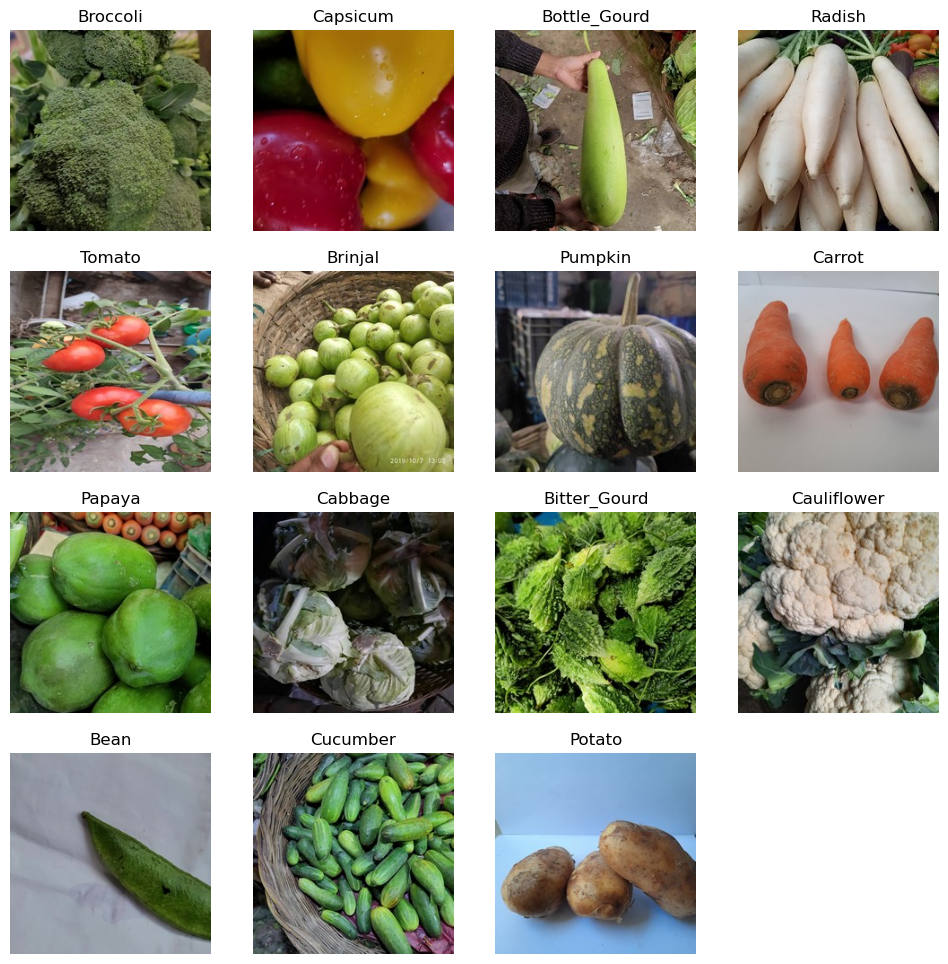

In [5]:
# Define the function to plot images from each category
def plot_images(image_categories, train_path):
    """
    Plot the first image from each category in a grid.
    
    Parameters:
        image_categories (list): A list of category names.
        train_path (str): The path to the folder containing subfolders for each category.
    """
    
    # Create a figure and set the size
    plt.figure(figsize=(12, 12))
    
    # Loop through each category and plot the first image from each
    for i, category in enumerate(image_categories):
        # Get the path to the first image in the current category folder
        category_path = os.path.join(train_path, category)
        images_in_folder = os.listdir(category_path)
        first_image_of_folder = images_in_folder[0]
        first_image_path = os.path.join(category_path, first_image_of_folder)
        
        # Load the image and convert it into a NumPy array, then normalize the values
        img = load_img(first_image_path, target_size=(224, 224))
        img_arr = img_to_array(img) / 255.0
        
        # Create a subplot and plot the image with its title and no axis
        # plt.subplot(rows, columns, index)
        plt.subplot(4, 4, i+1)
        plt.imshow(img_arr)
        plt.title(category)
        plt.axis('off')
        
    plt.show()

plot_images(vegetables_train, train_path)

## Create dataframe

In [6]:
# Function to create a DataFrame with image paths and labels
def create_dataframe(data_path):
    img_paths = [] # List to store image paths
    labels = [] # List to store labels

    # Loop through each vegetable directory in the data path
    for vegetable in os.listdir(data_path):
        # Full path to the vegetable directory
        directory = os.path.join(data_path, vegetable)
        
        # Loop through each image in the vegetable directory
        for image in os.listdir(directory):
            # Append image path to the list
            img_paths.append(os.path.join(directory, image))
            # Append corresponding label to the list
            labels.append(vegetable)
            
    # Create a DataFrame from the image paths and labels
    df = pd.DataFrame({"Image Path": img_paths, "Label": labels})
    return df

In [7]:
train_df = create_dataframe(train_path)
val_df = create_dataframe(val_path)
test_df = create_dataframe(test_path)

In [8]:
# Sort the training DataFrame based on the 'Label' column in place
train_df.sort_values("Label", inplace=True)
# Reset index
train_df.reset_index(drop=True, inplace=True)

val_df.sort_values("Label", inplace=True)
val_df.reset_index(drop=True, inplace=True)

test_df.sort_values("Label", inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [9]:
train_df.head()

,Image Path,Label
0,/kaggle/input/vegetable-image-dataset/Vegetabl...,Bean
1,/kaggle/input/vegetable-image-dataset/Vegetabl...,Bean
2,/kaggle/input/vegetable-image-dataset/Vegetabl...,Bean
3,/kaggle/input/vegetable-image-dataset/Vegetabl...,Bean
4,/kaggle/input/vegetable-image-dataset/Vegetabl...,Bean


In [10]:
# print the shape of training, validation and test data
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(15000, 2)
(3000, 2)
(3000, 2)


In [17]:
type(train_df)

pandas.core.frame.DataFrame

## ImageDataGenerator
ImageDataGenerator is used to perform real-time data augmentation and preprocessing on image data. Data augmentation is a technique used to artificially increase the size of the training dataset by applying various random transformations to the original images. These transformations include rotations, shifts, flips, zooms, brightness adjustments, and more. By applying such transformations, the model gets exposed to different variations of the input data, which can help improve its generalization and robustness.

In [14]:
dev_generator = image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True, # randomly flip images horizontally
    rotation_range=30, # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2, # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2, # randomly shift images vertically (fraction of total height)
    shear_range=0.2, 
    zoom_range=0.2,    
)

test_generator = image.ImageDataGenerator(rescale=1./255)

In [23]:
# Use data augmentation on training data
train_images = dev_generator.flow_from_dataframe(
    train_df, # DataFrame containing image paths and labels
    x_col = "Image Path", # Column name in DataFrame for image file paths
    y_col = "Label", # Column name in DataFrame for corresponding labels
    target_size = (100, 100), # Target size to which images will be resized during loading
    color_mode = "rgb", # Color mode of the loaded images ('rgb' for color images)
    class_mode = "categorical", # Type of labels to return ('categorical' for one-hot encoded labels)
    batch_size = 32, # Number of images to include in each batch
    shuffle = True, # Shuffle the data after each epoch (True or False)
    seed = 42, # Seed for reproducibility of shuffling and transformations
)

Found 15000 validated image filenames belonging to 15 classes.


In [20]:
# Print the class encodings done by the generators
class_map = dict([(v, k) for k, v in train_images.class_indices.items()])
print(class_map)

{0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}


In [24]:
# Use data augmentation on validation data
val_images = dev_generator.flow_from_dataframe(
    val_df,
    x_col = "Image Path",
    y_col = "Label",
    target_size = (100, 100),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 42,    
)

Found 3000 validated image filenames belonging to 15 classes.


In [186]:
class_map_val = dict([(v, k) for k, v in val_images.class_indices.items()])
print(class_map_val)

{0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}


In [25]:
# use data augmentation on test data
test_images = test_generator.flow_from_dataframe(
    test_df,
    x_col = "Image Path",
    y_col = "Y",
    target_size = (100, 100),
    color_mode = "rgb",
    class_mode = None,
    batch_size = 32,
    shuffle = False,
    seed=42,  
)

Found 3000 validated image filenames.


### Model development

In [26]:
sgd = SGD(learning_rate=0.1)

Stochastic Gradient Descent (SGD) is an optimization algorithm commonly used in machine learning for training models, especially neural networks. Its primary goal is to find the optimal set of parameters (weights and biases) that minimize the error (loss) between the model's predictions and the actual target values on the training data.
<br>The key idea behind SGD is to update the model's parameters in the direction that reduces the loss, based on the gradient of the loss function with respect to those parameters. The gradient points in the direction of the steepest increase in the loss function, so moving in the opposite direction of the gradient allows us to descend the loss function towards its minimum.
<br> Learning rate represents how far the optimizer should move in the direction opposite to the gradient in each update. A higher learning rate means larger steps, which can lead to faster convergence but may also risk overshooting the optimal solution. On the other hand, a lower learning rate takes smaller steps, making it more likely to reach the minimum but might be slower to converge.

In [27]:
model=Sequential([
    # Convolutional layer with 16 filters, each of size (3, 3),
    # using ReLU activation function, and input shape (100, 100, 3)
    Conv2D(filters=16, kernel_size=(3,3), activation="relu", input_shape=(100,100,3)),
    
    # MaxPooling layer reduces the spatial dimensions of the feature maps
    MaxPooling2D(pool_size=(2,2)),
    
    # BatchNormalization layer to normalize the activations 
    # of the previous layer, stabilizing the learning process
    BatchNormalization(),
    
    Conv2D(filters=32, kernel_size=(3,3), activation="relu"),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(filters=64,kernel_size=(3,3), activation="relu"),
    MaxPooling2D(pool_size=(2,2)),
    
    # Flatten layer to convert the 3D feature maps into 
    # a 1D vector for the fully connected layers
    Flatten(),
    
    # Dropout layer helps prevent overfitting
    Dropout(0.2),
    Dense(512, activation="relu"),
    Dropout(0.2),
    Dense(256, activation="relu"),
    Dense(15, activation="softmax")
])

#### Explaination of the layer inside the model
The first layer takes the input of the image in. **Input shape** is (100, 100, 3) which stands for (height, width, channel). Channel is mostly 3 because to make a pixel colorful, you need red, green, and blue (RGB). If a pixel is only black and white, you would have 1 channel
<br>**Filter** is a small-sized matrix used for the convolution operation. Convolution is a fundamental operation in CNNs that allows the network to extract features from images. During the training process, the filters slide over the input and try to detect specific patterns or features in the input data. These patterns can represent simple features like edges, textures, or colors, or more complex patterns like shapes or object parts. In out code the filter has a size of 3x3
<br>**MaxPooling** is a downsampling technique for reducing the spatial dimensions of the feature maps produced by convolutional layers. It helps to decrease the computational complexity of the network and extract the most important information while retaining the relevant features. With the size of (2,2) the feature maps are reduced by a factor of 2 in both width and height.
<br>**BatchNormalization** reduce internal covariate shift, which refers to the change in the distribution of activations in the intermediate layers during training.
<br>**Dropout** is a regularization technique that introduces randomness during the training process by randomly deactivating (or "dropping out") a fraction of neurons or units in a layer. The primary objective of Dropout is to reduce the model's reliance on specific neurons, promoting the learning of more robust and general features. For instance, with a dropout rate of 0.2, approximately 20% of the neuron outputs are excluded from the subsequent layer.
<br>**Last layer** has 15 neurons because we have 15 classes. Softmax is used because Softmax transforms the raw scores (logits) into a probability distribution, where each value represents the likelihood of the input belonging to a specific class. By using softmax, the model produces probabilities that sum up to 1 across all classes, allowing us to interpret the outputs as class probabilities.

In [29]:
#compile model
model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["acc", "mse"])

In [30]:
# add early stop to the model
early_stop = EarlyStopping(monitor="val_loss", patience=8, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=4, verbose=1, min_delta=1e-4) 
callbacks_list = [early_stop, reduce_lr]

In [31]:
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 49, 49, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                        

In [32]:
# train the model
history = model.fit(train_images, validation_data = val_images, epochs = 40, callbacks = callbacks_list)

Epoch 1/40
469/469 [==============================] - 167s 339ms/step - loss: 1.7443 - acc: 0.4083 - mse: 0.0478 - val_loss: 1.5546 - val_acc: 0.4633 - val_mse: 0.0439 - lr: 0.0100
Epoch 2/40
469/469 [==============================] - 69s 147ms/step - loss: 1.1740 - acc: 0.6078 - mse: 0.0350 - val_loss: 1.1252 - val_acc: 0.6113 - val_mse: 0.0340 - lr: 0.0100
Epoch 3/40
469/469 [==============================] - 69s 146ms/step - loss: 0.9355 - acc: 0.6864 - mse: 0.0287 - val_loss: 1.1440 - val_acc: 0.6277 - val_mse: 0.0332 - lr: 0.0100
Epoch 4/40
469/469 [==============================] - 69s 148ms/step - loss: 0.7853 - acc: 0.7337 - mse: 0.0245 - val_loss: 0.6466 - val_acc: 0.7843 - val_mse: 0.0205 - lr: 0.0100
Epoch 5/40
469/469 [==============================] - 68s 144ms/step - loss: 0.6684 - acc: 0.7745 - mse: 0.0212 - val_loss: 0.7481 - val_acc: 0.7377 - val_mse: 0.0239 - lr: 0.0100
Epoch 6/40
469/469 [==============================] - 72s 154ms/step - loss: 0.5846 - acc: 0.8069 -

In [64]:
def plot_metric(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f"val_{metric}"])
    plt.title(f"model {metric}")
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

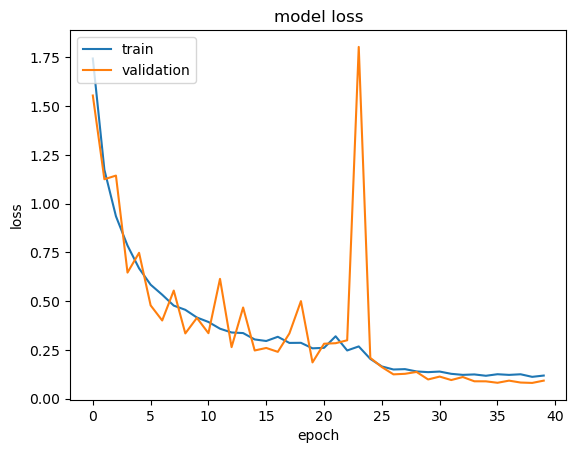

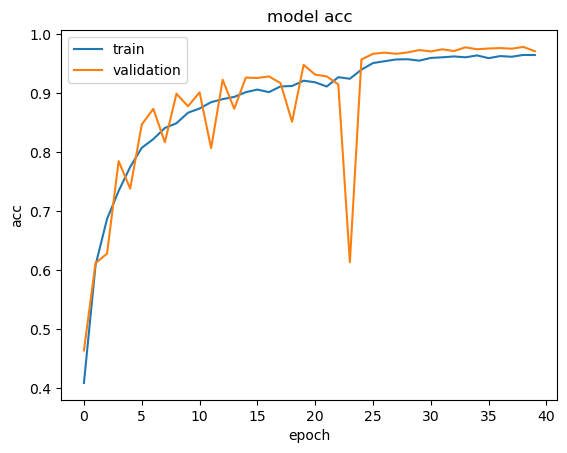

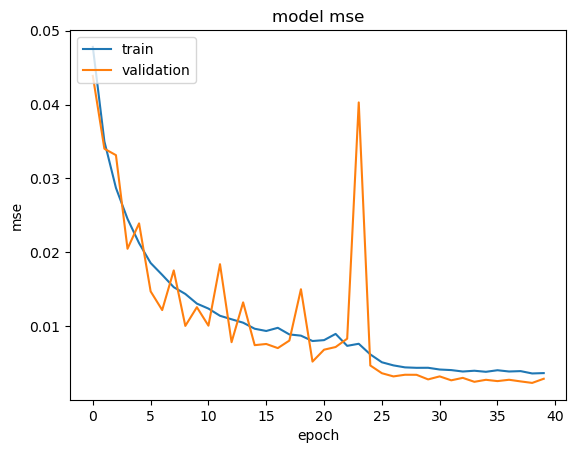

In [66]:
plot_metric(history, "loss")
plot_metric(history, "acc")
plot_metric(history, "mse")

## Test CNN model and export it

In [38]:
def img_preprocessing(img_path):
    image = load_img(img_path, target_size=(100, 100))
    image_array = img_to_array(image)
    image_array = image_array / 255.0  # Normalize the values
    image_array = np.expand_dims(image_array, axis=0)  # Adding a Batch-Dimension (1, 100, 100, 3)
    return image_array

In [39]:
test_img_path = "/kaggle/input/vegetable-image-dataset/Vegetable Images/train/Bean/0026.jpg"
test_img = img_preprocessing(test_img_path)

In [40]:
prediction = model.predict(test_img)

1/1 [==============================] - 0s 172ms/step


In [42]:
print(class_map)

{0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}


In [47]:
prediction_class = class_map[np.argmax(prediction)]
prediction_prob = np.max(prediction)

print("Prediction: ", vorhersage_klasse, "- probability: ", prediction_prob)

Prediction:  Radish - probability:  0.8674042


In [48]:
model.save("model_vegetables_cnn.h5")

## Transfer Learning

In [57]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [83]:
IMAGE_SIZE = [100, 100]

# [3] -> color channel
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False

x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation="relu")(x)
x = Dropout(0.2)(x)

prediction = Dense(15, activation="softmax")(x)

model_tf = Model(inputs=inception.input, outputs=prediction)

model_tf.compile(
  loss="categorical_crossentropy",
  optimizer="adam",
  metrics=["accuracy"]
)

## Some explaination to InceptionV3

- **include_top=False**: The final fully connected layers of the InceptionV3 model, responsible for ImageNet classification, will not be included. We will add our custom layers on top of the model.
- **weights='imagenet'**: The model will be initialized with pre-trained weights on the ImageNet dataset
- **layer.trainable=False**: The weights of the pre-trained InceptionV3 layers will be freezed, and they will not be updated during the training process.
- **x = inception.output**: Captures the output tensor of the InceptionV3 model. We will use this as the input to our custom classification layers.

In [110]:
r = model_tf.fit(
  train_images,
  validation_data = val_images,
  epochs = 10,
  steps_per_epoch = len(train_images),
  validation_steps = len(val_images)
)

Epoch 1/10
469/469 [==============================] - 76s 161ms/step - loss: 0.4979 - accuracy: 0.8437 - val_loss: 0.3938 - val_accuracy: 0.8780
Epoch 2/10
469/469 [==============================] - 75s 159ms/step - loss: 0.4971 - accuracy: 0.8449 - val_loss: 0.3859 - val_accuracy: 0.8747
Epoch 3/10
469/469 [==============================] - 79s 168ms/step - loss: 0.4793 - accuracy: 0.8466 - val_loss: 0.4263 - val_accuracy: 0.8660
Epoch 4/10
469/469 [==============================] - 77s 164ms/step - loss: 0.4766 - accuracy: 0.8475 - val_loss: 0.4026 - val_accuracy: 0.8710
Epoch 5/10
469/469 [==============================] - 73s 155ms/step - loss: 0.4764 - accuracy: 0.8461 - val_loss: 0.4231 - val_accuracy: 0.8637
Epoch 6/10
469/469 [==============================] - 72s 154ms/step - loss: 0.4715 - accuracy: 0.8482 - val_loss: 0.3840 - val_accuracy: 0.8730
Epoch 7/10
469/469 [==============================] - 72s 154ms/step - loss: 0.4754 - accuracy: 0.8460 - val_loss: 0.3668 - val_ac

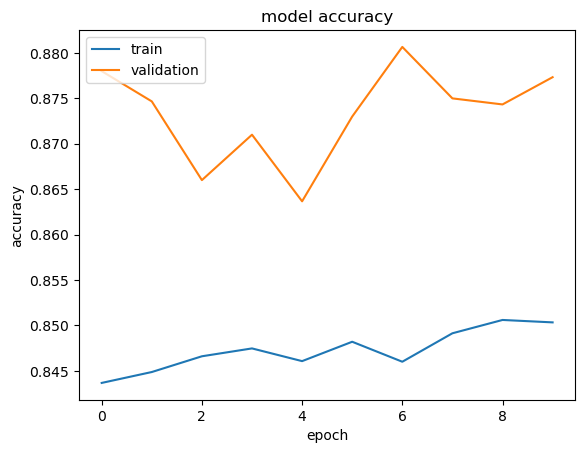

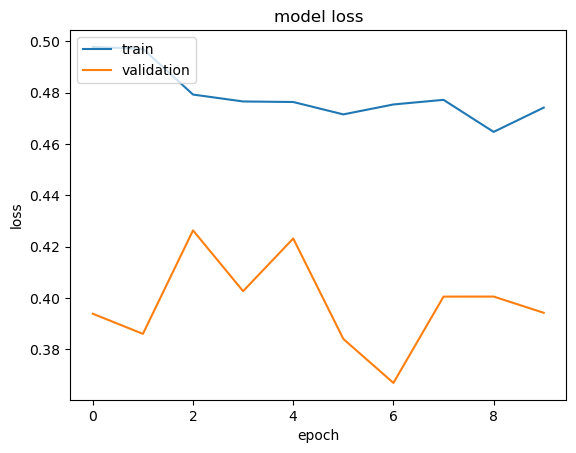

In [112]:
plot_metric(r, "accuracy")
plot_metric(r, "loss")

t might be a good idea to decrease the number of epochs. The validation accuracy stops improving after the 5th epoch, but the training accuracy keeps increasing. This suggests that the model might be overfitting.

In [113]:
scores = model_tf.evaluate_generator(val_images)
print("Test Accuracy: {:.3f}".format(scores[1]))

/tmp/ipykernel_962/3065760293.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model_tf.evaluate_generator(val_images)


Test Accuracy: 0.874


#### An accuracy of 87% on validation dataset seems decent through

In [114]:
# Load and preprocess the test image
test_img_path = "/kaggle/input/vegetable-image-dataset/Vegetable Images/train/Pumpkin/0001.jpg"
test_image = load_img(test_img_path, target_size=(100, 100))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = preprocess_input(test_image)

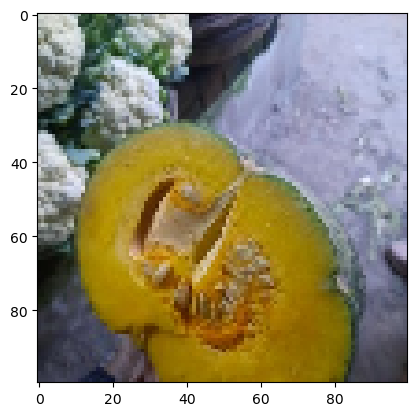

In [115]:
test_img_display = load_img(test_img_path, target_size=(100, 100))
img_arr = img_to_array(test_img_display) / 255.0
plt.imshow(img_arr)

In [116]:
prediction_tf = model_tf.predict(test_image)

1/1 [==============================] - 0s 27ms/step


In [117]:
prediction_class = class_map[np.argmax(prediction_tf)]
prediction_prob = np.max(prediction_tf)

print("Transfer Learning prediction: ", vorhersage_klasse, "- probability: ", prediction_prob)

Transfer Learning prediction:  Radish - probability:  0.4387485


An accuracy rate of **43%** is relatively low. Let's give it another attempt, but this time using the original size of the image.

### Train Transfer Learning on the 224x224

#### Create generator

In [137]:
# Use data augmentation on training data
train_images_tf = dev_generator.flow_from_dataframe(
    train_df,
    x_col = "Image Path",
    y_col = "Label",
    target_size = (224, 224),
    color_mode = "rgb",
    batch_size = 32,
    shuffle = False,
    seed = 42, 
)

Found 15000 validated image filenames belonging to 15 classes.


In [138]:
# use data augmentation on test data
test_images_tf = test_generator.flow_from_dataframe(
    test_df,
    x_col = "Image Path",
    y_col = "Label",
    target_size = (224, 224),
    color_mode = "rgb",
    class_mode = None,
    batch_size = 32,
    shuffle = False,
    seed=42,  
)

Found 3000 validated image filenames.


In [139]:
# Use data augmentation on validation data
val_images_tf = dev_generator.flow_from_dataframe(
    val_df,
    x_col = "Image Path",
    y_col = "Label",
    target_size = (224, 224),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 42,    
)

Found 3000 validated image filenames belonging to 15 classes.


#### Train model

In [140]:
IMAGE_SIZE = [224, 224]

# [3] -> color channel
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False

x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation="relu")(x)
x = Dropout(0.2)(x)

prediction = Dense(15, activation="softmax")(x)

model_tf = Model(inputs=inception.input, outputs=prediction)

model_tf.compile(
  loss="categorical_crossentropy",
  optimizer="adam",
  metrics=["accuracy"]
)

In [141]:
r = model_tf.fit(
  train_images_tf,
  validation_data = val_images_tf,
  epochs = 5,
  steps_per_epoch = len(train_images_tf),
  validation_steps = len(val_images_tf)
)

Epoch 1/5
469/469 [==============================] - 230s 479ms/step - loss: 1.3213 - accuracy: 0.6177 - val_loss: 0.3566 - val_accuracy: 0.8893
Epoch 2/5
469/469 [==============================] - 222s 474ms/step - loss: 0.4030 - accuracy: 0.8759 - val_loss: 0.2156 - val_accuracy: 0.9353
Epoch 3/5
469/469 [==============================] - 220s 469ms/step - loss: 0.2636 - accuracy: 0.9172 - val_loss: 0.1583 - val_accuracy: 0.9460
Epoch 4/5
469/469 [==============================] - 212s 451ms/step - loss: 0.1977 - accuracy: 0.9372 - val_loss: 0.0898 - val_accuracy: 0.9713
Epoch 5/5
469/469 [==============================] - 214s 455ms/step - loss: 0.1631 - accuracy: 0.9489 - val_loss: 0.0984 - val_accuracy: 0.9727


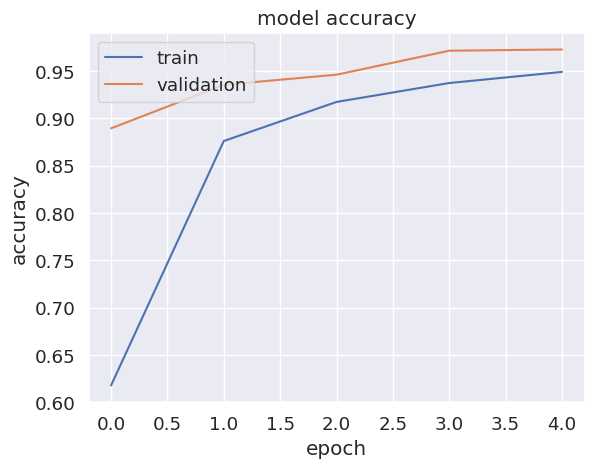

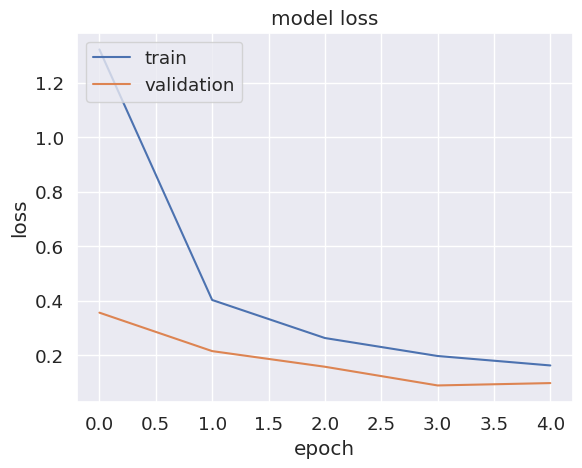

In [193]:
plot_metric(r, "accuracy")
plot_metric(r, "loss")

In [181]:
scores = model_tf.evaluate(val_images_tf)
print("Test Accuracy: {:.3f}".format(scores[1]))

94/94 [==============================] - 36s 379ms/step - loss: 0.0944 - accuracy: 0.9733
Test Accuracy: 0.973


#### The test accuracy is 97%

#### Test and export the model

In [154]:
test_img_path_tf = "/kaggle/input/vegetable-image-dataset/Vegetable Images/train/Pumpkin/0002.jpg"
test_image_tf = load_img(test_img_path_tf, target_size=(224, 224))
test_image_tf = img_to_array(test_image_tf)
test_image_tf = np.expand_dims(test_image_tf, axis=0)
test_image_tf = preprocess_input(test_image_tf)

In [155]:
prediction_tf = model_tf.predict(test_image_tf)

1/1 [==============================] - 0s 27ms/step


In [156]:
prediction_class_tf = class_map[np.argmax(prediction_tf)]
prediction_prob_tf = np.max(prediction_tf)

print("Transfer Learning prediction: ", prediction_class_tf, "- probability: ", prediction_prob_tf)

Transfer Learning prediction:  Pumpkin - probability:  0.9997975


In [194]:
model_tf.save("veg_tf.h5")

#### Comparison CNN and Transfer Learning

In [182]:
def labels_confusion_matrix(validation_folder):
    
    folder_path=validation_folder
    
    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i
    
    files=[]
    real=[]
    predicted=[]

    for i in tqdm(os.listdir(folder_path)):
        
        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]
        
        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = load_img(os.path.join(folder_path,i,j), target_size=(224,224))
            img_array = img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0) 
            img_processed /= 255.
            prediction = model.predict(img_processed, verbose=0)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)
            
    return (real,predicted)

def print_confusion_matrix(real,predicted):
    total_output_labels = 15
    cmap="turbo"
    cm_plot_labels = [i for i in range(15)]
    
    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.2) # for label size
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap) # font size

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

100%|██████████| 15/15 [03:40<00:00, 14.71s/it]


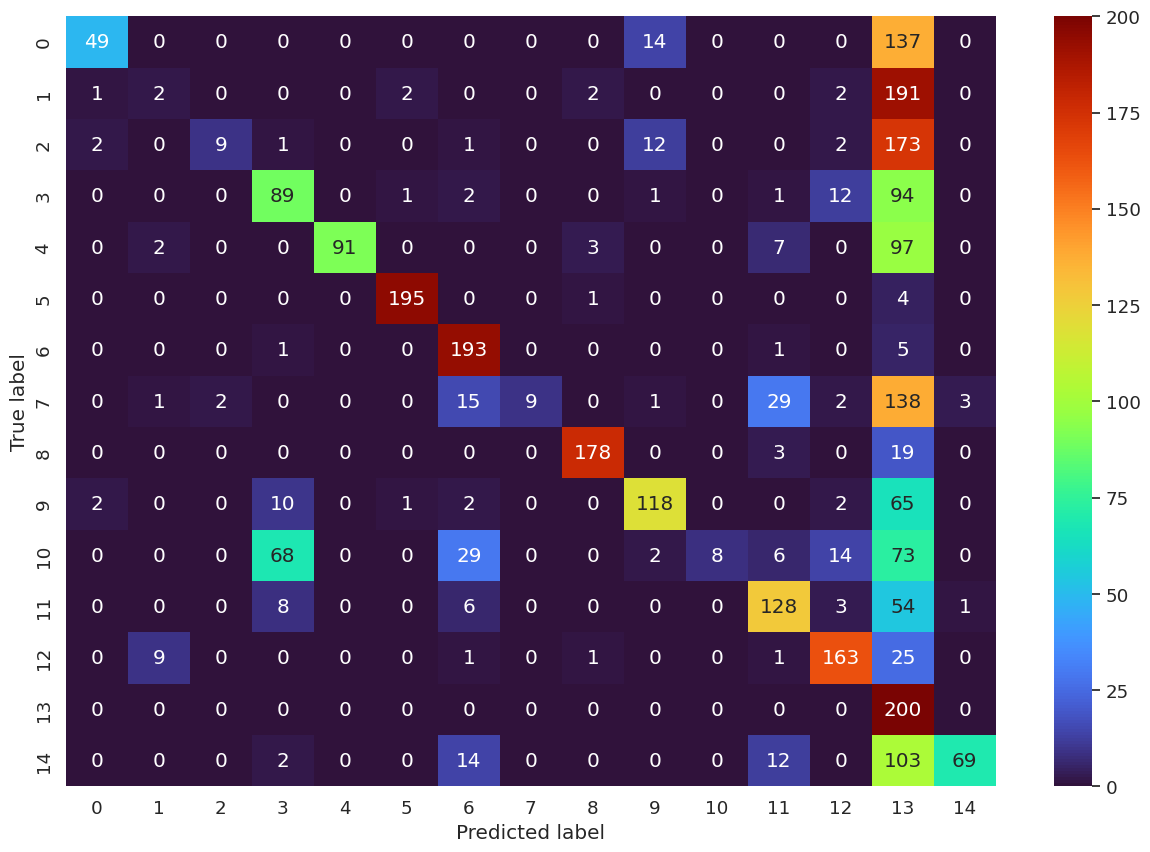

In [185]:
y_true,y_pred = labels_confusion_matrix(test_path)
print_confusion_matrix(y_true,y_pred)

In [188]:
print(class_map)

{0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}


Class 13, representing radishes, poses a unique challenge for the **transfer learning model** as it tends to consistently classify everything as radishes. Particularly, Bitter Gourd was only correctly identified twice, and the rest of its instances were mislabeled as radishes. We could playfully call it "radischmania" given the model's strong association with radishes :))

In [190]:
model_cnn = load_model("/kaggle/working/model_vegetables_cnn.h5")

In [191]:
def labels_confusion_matrix_cnn(validation_folder):
    
    folder_path=validation_folder
    
    mapping={}
    for i,j in enumerate(sorted(os.listdir(folder_path))):
        mapping[j]=i
    
    files=[]
    real=[]
    predicted=[]

    for i in tqdm(os.listdir(folder_path)):
        
        true=os.path.join(folder_path,i)
        true=true.split('/')[-1]
        true=mapping[true]
        
        for j in os.listdir(os.path.join(folder_path,i)):

            img_ = load_img(os.path.join(folder_path,i,j), target_size=(100,100))
            img_array = img_to_array(img_)
            img_processed = np.expand_dims(img_array, axis=0) 
            img_processed /= 255.
            prediction = model_cnn.predict(img_processed, verbose=0)
            index = np.argmax(prediction)

            predicted.append(index)
            real.append(true)
            
    return (real,predicted)

100%|██████████| 15/15 [02:49<00:00, 11.30s/it]


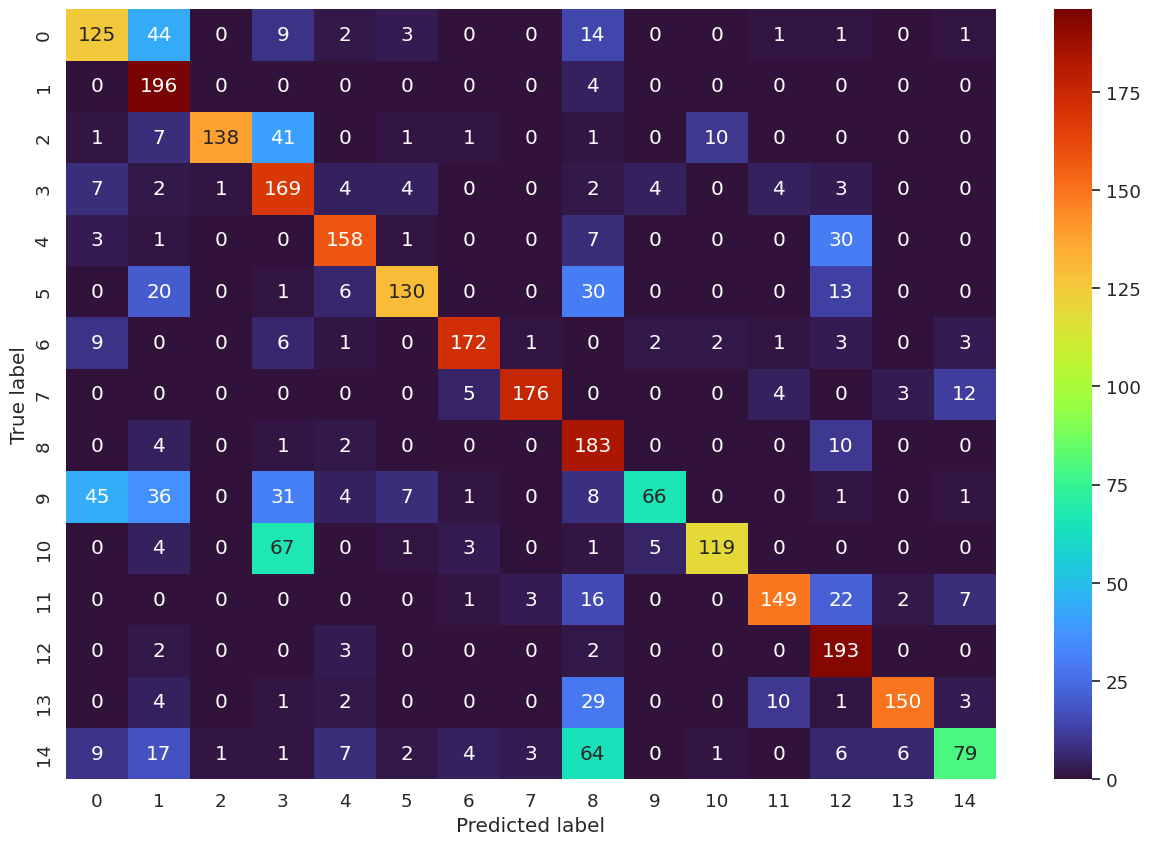

In [192]:
y_true,y_pred = labels_confusion_matrix_cnn(test_path)
print_confusion_matrix(y_true,y_pred)

In [178]:
scores_tf = model_tf.evaluate(val_images_tf)
print("Test Accuracy: {:.3f}".format(scores_tf[1]))

94/94 [==============================] - 36s 384ms/step - loss: 0.1025 - accuracy: 0.9703
Test Accuracy: 0.970


In [180]:
scores_cnn = model_cnn.evaluate(val_images)
print("Test Accuracy: {:.3f}".format(scores_cnn[1]))

94/94 [==============================] - 12s 120ms/step - loss: 0.1026 - acc: 0.9743 - mse: 0.0029
Test Accuracy: 0.974


#### Conclusion
Transfer Learning accuracy: 97,0%
<br>CNN accuracy: 97,4%
<br>The CNN's accuracy, compared to Transfer Learning, is only slightly higher, approximately 0.4%. Although both models perform well, there are some noteworthy differences. 
<br> In term of **training time**, the CNN required a significantly longer duration as it underwent 40 epochs, while Transfer Learning only needed 5 epochs, making it notably faster. Thus, if time efficiency is a critical factor, Transfer Learning emerges as the preferable choice.
<br> In terms of **accuracy**, the CNN appears to be the more favorable option. While both models perform well overall, Transfer Learning encountered difficulties, particularly with bottle gourd images, where it failed to correctly label them. This raises concerns about the Transfer Learning model's ability to effectively learn and adapt to novel concepts. Consequently, the CNN's superior accuracy makes it a more reliable choice in this context.

### sources
https://www.kaggle.com/code/serxio/vegetables-classification-cnn
<br>https://www.kaggle.com/code/chitwanmanchanda/vegetable-image-classification-using-cnn
<br>https://www.kaggle.com/code/theeyeschico/vegetable-classification-using-transfer-learning